In [ ]:
from d2l import tensorflow as d2l
import tensorflow as tf
import numpy as np
import math

In [ ]:
!pip install d2l==0.14.4

     |████████████████████████████████| 61kB 4.1MB/s 


In [ ]:
#4.4 Model Selection

In [ ]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [ ]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [tf.constant(x, dtype=
    tf.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[0.7427412 ],
        [0.02879653]], dtype=float32)>,
 <tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[1.0000000e+00, 7.4274123e-01, 2.7583227e-01, 6.8290666e-02,
         1.2680573e-02, 1.8836770e-03, 2.3318076e-04, 2.4741852e-05,
         2.2970992e-06, 1.8957226e-07, 1.4080313e-08, 9.5072994e-10,
         5.8845526e-11, 3.3620769e-12, 1.7836808e-13, 8.8320888e-15,
         4.0999727e-16, 1.7913051e-17, 7.3915345e-19, 2.8894724e-20],
        [1.0000000e+00, 2.8796526e-02, 4.1461995e-04, 3.9798715e-06,
         2.8651618e-08, 1.6501341e-10, 7.9196881e-13, 3.2579928e-15,
         1.1727360e-17, 3.7523023e-20, 1.0805327e-22, 2.8286898e-25,
         6.7880369e-28, 1.5036298e-30, 3.0928083e-33, 5.9374755e-36,
         1.0686166e-38, 1.8101974e-41, 2.9427268e-44, 0.0000000e+00]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([5.3292694, 5.0044274], dtype=float32)>)

In [ ]:
def evaluate_loss(net, data_iter, loss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(tf.reduce_sum(l), tf.size(l).numpy())
    return metric[0] / metric[1]

In [ ]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = tf.losses.MeanSquaredError()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1, use_bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    trainer = tf.keras.optimizers.SGD(learning_rate=.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net.get_weights()[0].T)

weight: [[ 4.98945    1.1688374 -3.381537   5.640259 ]]


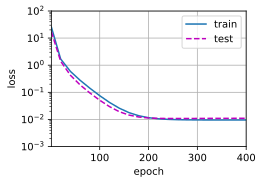

In [ ]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[2.489514  4.1598744]]


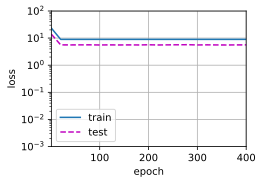

In [ ]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.97836351e+00  1.22782564e+00 -3.35342097e+00  5.31587553e+00
  -1.39680371e-01  1.02568424e+00  4.66782272e-01  3.72974835e-02
   2.16147974e-01 -4.92126256e-01 -6.52745739e-02  4.17911679e-01
   3.17682385e-01 -3.69303860e-04  1.01500556e-01 -1.05708912e-02
  -5.15405715e-01  4.23947692e-01  1.84150815e-01 -4.10240740e-01]]


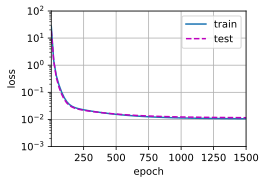

In [ ]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

In [ ]:
#4.5 weight decay

In [ ]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = tf.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [ ]:
def init_params():
    w = tf.Variable(tf.random.normal(mean=1, shape=(num_inputs, 1)))
    b = tf.Variable(tf.zeros(shape=(1, )))
    return [w, b]

In [ ]:
def l2_penalty(w):
    return tf.reduce_sum(tf.pow(w, 2)) / 2

In [ ]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                # The L2 norm penalty term has been added, and broadcasting
                # makes `l2_penalty(w)` a vector whose length is `batch_size`
                l = loss(net(X), y) + lambd * l2_penalty(w)
            grads = tape.gradient(l, [w, b])
            d2l.sgd([w, b], grads, lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', tf.norm(w).numpy())

L2 norm of w: 18.455608


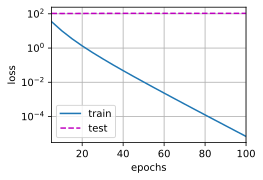

In [ ]:
train(lambd=0)

L2 norm of w: 0.51766634


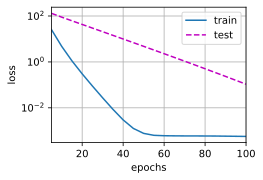

In [ ]:
train(lambd=3)

In [ ]:
def train_concise(wd):
    net = tf.keras.models.Sequential()
    net.add(tf.keras.layers.Dense(
        1, kernel_regularizer=tf.keras.regularizers.l2(wd)))
    net.build(input_shape=(1, num_inputs))
    w, b = net.trainable_variables
    loss = tf.keras.losses.MeanSquaredError()
    num_epochs, lr = 100, 0.003
    trainer = tf.keras.optimizers.SGD(learning_rate=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                # `tf.keras` requires retrieving and adding the losses from
                # layers manually for custom training loop.
                l = loss(net(X), y) + net.losses
            grads = tape.gradient(l, net.trainable_variables)
            trainer.apply_gradients(zip(grads, net.trainable_variables))
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', tf.norm(net.get_weights()[0]).numpy())

L2 norm of w: 1.2907445


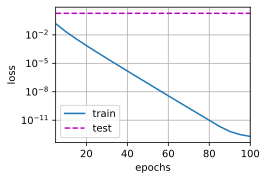

In [ ]:
train_concise(0)

L2 norm of w: 0.028680595


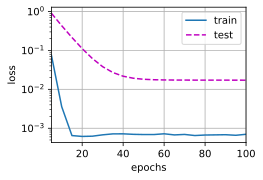

In [ ]:
train_concise(3)

In [ ]:
#4.6 dropout

In [ ]:
from d2l import tensorflow as d2l
import tensorflow as tf

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # In this case, all elements are dropped out
    if dropout == 1:
        return tf.zeros_like(X)
    # In this case, all elements are kept
    if dropout == 0:
        return X
    mask = tf.random.uniform(
        shape=tf.shape(X), minval=0, maxval=1) < 1 - dropout
    return tf.cast(mask, dtype=tf.float32) * X / (1.0 - dropout)

In [ ]:
X = tf.reshape(tf.range(16, dtype=tf.float32), (2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tf.Tensor(
[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]], shape=(2, 8), dtype=float32)
tf.Tensor(
[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]], shape=(2, 8), dtype=float32)
tf.Tensor(
[[ 0.  2.  4.  0.  0.  0.  0. 14.]
 [16.  0. 20.  0.  0.  0. 28.  0.]], shape=(2, 8), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]], shape=(2, 8), dtype=float32)


In [ ]:
num_outputs, num_hiddens1, num_hiddens2 = 10, 256, 256

In [ ]:
dropout1, dropout2 = 0.2, 0.5

class Net(tf.keras.Model):
    def __init__(self, num_outputs, num_hiddens1, num_hiddens2):
        super().__init__()
        self.input_layer = tf.keras.layers.Flatten()
        self.hidden1 = tf.keras.layers.Dense(num_hiddens1, activation='relu')
        self.hidden2 = tf.keras.layers.Dense(num_hiddens2, activation='relu')
        self.output_layer = tf.keras.layers.Dense(num_outputs)

    def call(self, inputs, training=None):
        x = self.input_layer(inputs)
        x = self.hidden1(x)
        if training:
            x = dropout_layer(x, dropout1)
        x = self.hidden2(x)
        if training:
            x = dropout_layer(x, dropout2)
        x = self.output_layer(x)
        return x

net = Net(num_outputs, num_hiddens1, num_hiddens2)

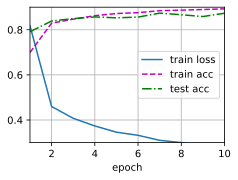

In [ ]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = tf.keras.optimizers.SGD(learning_rate=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [ ]:
net = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    # Add a dropout layer after the first fully connected layer
    tf.keras.layers.Dropout(dropout1),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    # Add a dropout layer after the second fully connected layer
    tf.keras.layers.Dropout(dropout2),
    tf.keras.layers.Dense(10),
])

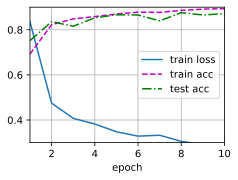

In [ ]:
trainer = tf.keras.optimizers.SGD(learning_rate=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)